In [1]:
import matplotlib.pyplot as plt
from torch.utils import data
import numpy as np
from tqdm import tqdm
import random
from visualisationMetrics import *
from dataLoader import *
from utils.utils import *
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from collections import defaultdict
from LoadSynthetic import *

In [173]:
LOGDIR = 'reweighted_with_var_correction6'
hyperparams = from_json(f'logs/{LOGDIR}/hyperparameters.json')
SEQ_LEN = hyperparams['seq_len']

### Step 1: Load real data

In [174]:
real_data = load_dataset(data_mode='Train', output_size=SEQ_LEN)
real_dataloader = data.DataLoader(real_data, batch_size=1, num_workers=1, shuffle=True)
print(f"gen ~ N({real_data.Y.mean()}, {real_data.Y_test.var(axis=-1).mean()})")

[*********************100%%**********************]  1 of 1 completed


X_train's shape is (4344, 1, 1, 3), X_test's shape is (485, 1, 1, 3)
y_train's label shape is (4344, 1, 1, 43), y_test's label shape is (485, 1, 1, 43)
gen ~ N(1.0091222524642944, 0.0008087196038104594)


In [175]:
real_paths = []
real_conds = []

for i, (cond, sim) in enumerate(real_dataloader):
    sim = sim.cpu().detach().numpy()
    sim = sim.reshape(sim.shape[1], sim.shape[3])
    real_paths.append(sim)
    cond = cond.cpu().detach().numpy()
    cond = cond.reshape(cond.shape[1], cond.shape[3])
    real_conds.append(cond)

real_paths = np.array(real_paths)
real_conds = np.array(real_conds)
print(real_paths.shape)
print(real_conds.shape)

(485, 1, 43)
(485, 1, 3)


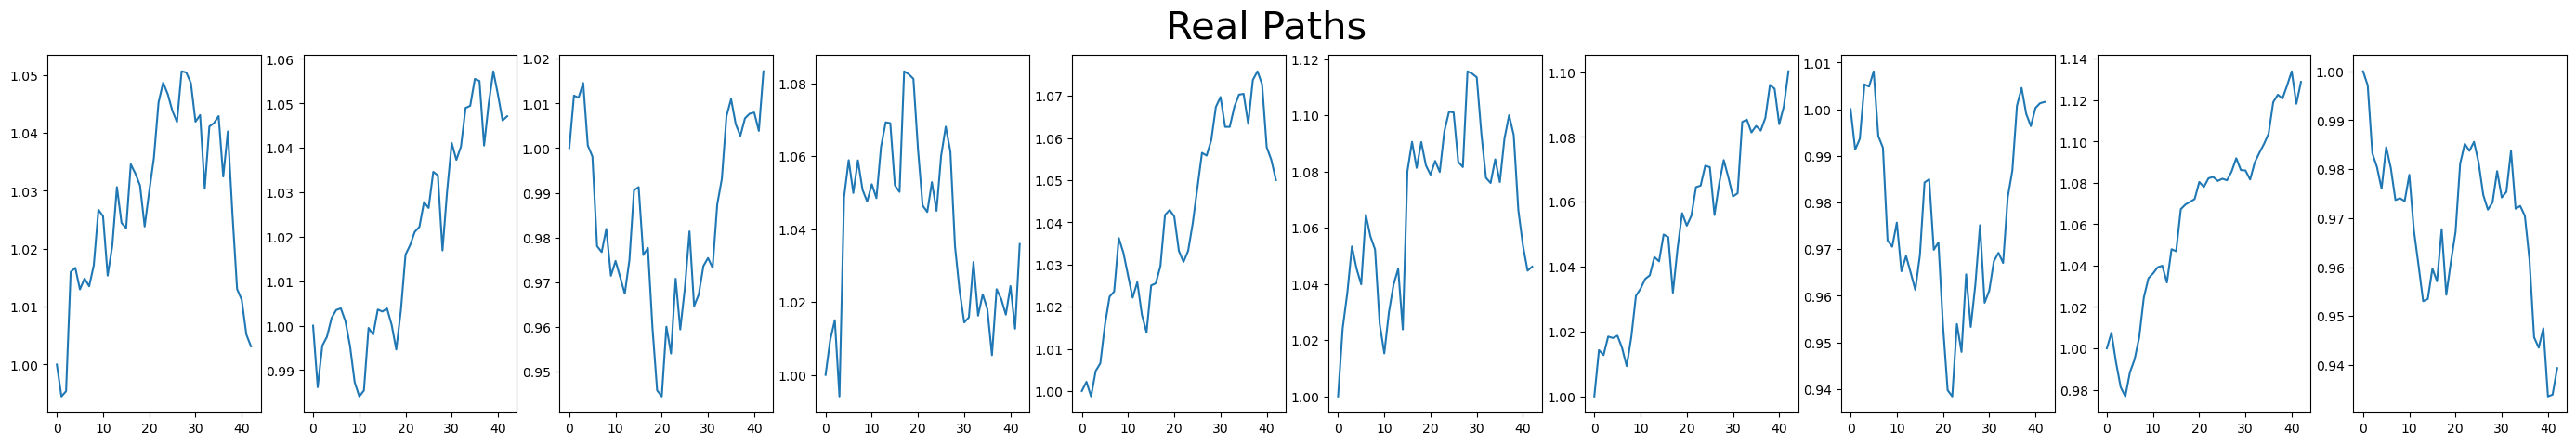

In [176]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Real Paths', fontsize=30)
for i in range(10):
    for path in real_paths[i]:
        axs[i].plot(path[:])

### Step 2: Load synthetic data

In [177]:
syn_data = Synthetic_Dataset(model_path=f'./logs/{LOGDIR}', n=10, dataset=real_data)
syn_dataloader = data.DataLoader(syn_data, batch_size=1, num_workers=1, shuffle=True)

In [178]:
syn_paths = []
syn_conds = []

for i, (cond, sim) in enumerate(syn_dataloader):
    sim = sim.cpu().detach().numpy()
    sim = sim.reshape(sim.shape[1], sim.shape[3])
    syn_paths.append(sim)
    cond = cond.cpu().detach().numpy()
    cond = cond.reshape(cond.shape[1], cond.shape[3])
    syn_conds.append(cond)
    
syn_paths = np.array(syn_paths)
syn_conds = np.array(syn_conds)
print(syn_paths.shape)
print(syn_conds.shape)

(4850, 1, 43)
(4850, 1, 3)


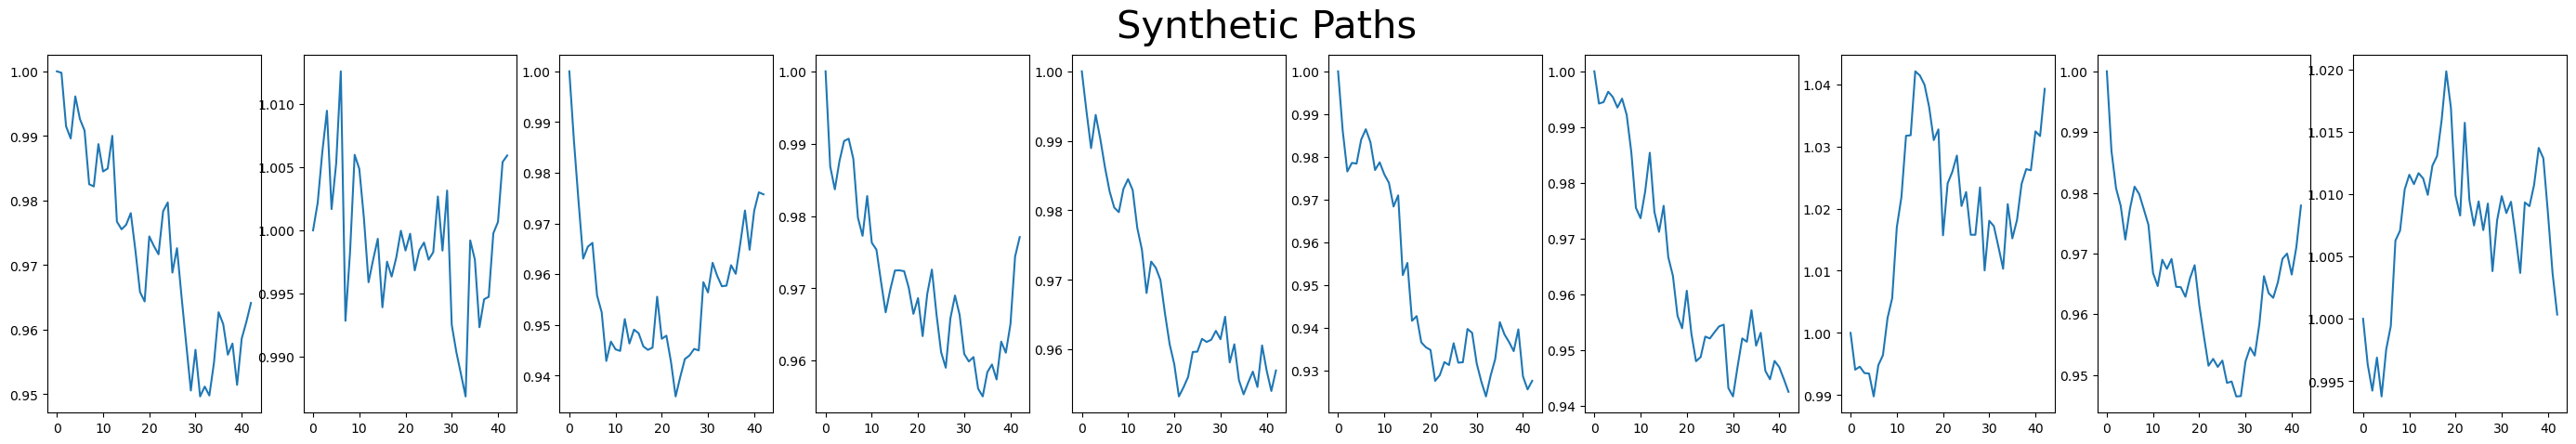

In [179]:
np.random.shuffle(syn_paths)
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Synthetic Paths', fontsize=30)
for i in range(10):
    for path in syn_paths[i]:
        axs[i].plot(path[:])

### Step 3: Load benchmark data

In [180]:
simulator = GBM_Simulator(dataset=real_data)
gbm_paths = simulator.run()
gbm_paths = np.reshape(gbm_paths, (-1,1,gbm_paths.shape[-1]))

print(gbm_paths.shape)

(4370, 1, 43)


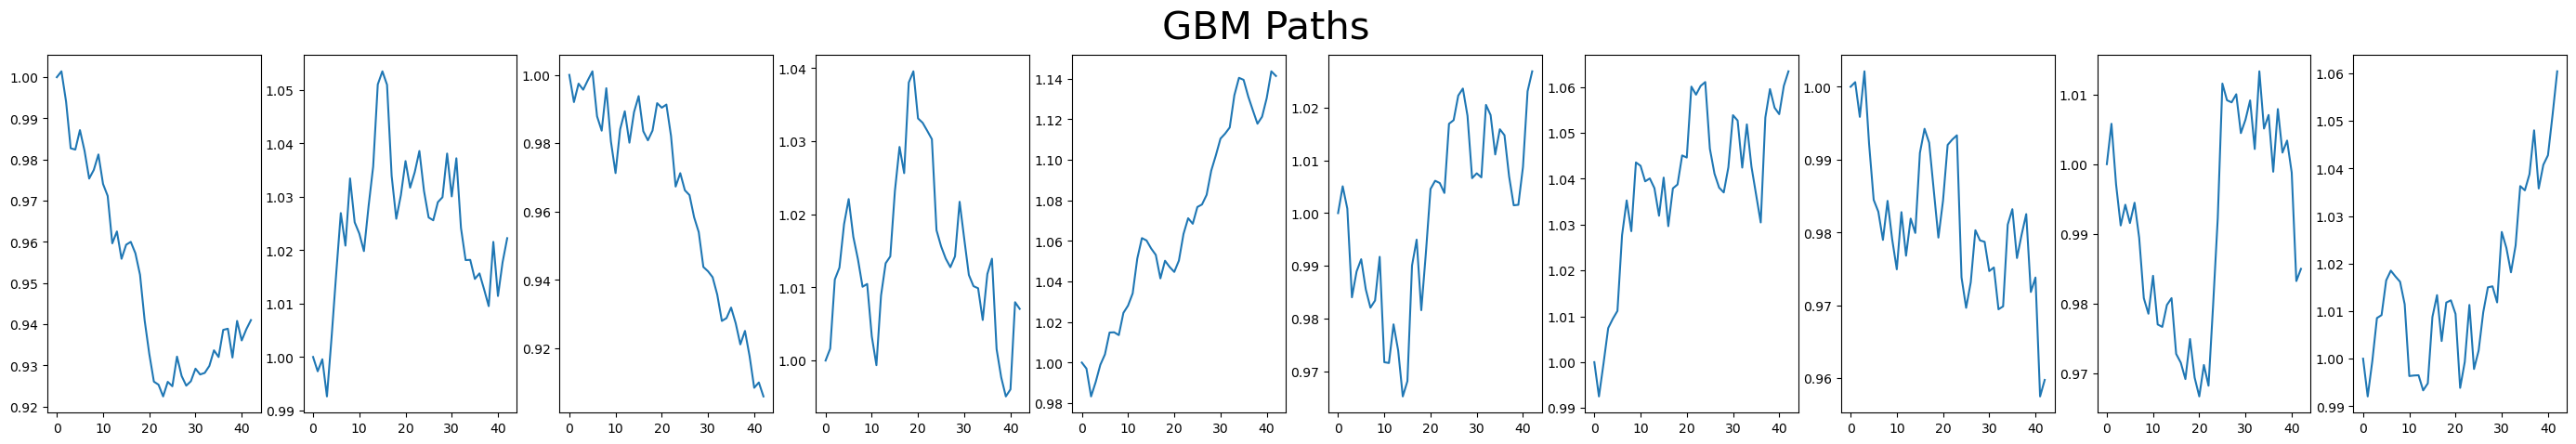

In [181]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('GBM Paths', fontsize=30)
samples = random.sample(range(len(gbm_paths)),k=10)
for i in range(10):
    for sim in gbm_paths[samples[i]]:
        axs[i].plot(sim[:])

### Dimensionality Reduction

In [182]:
real_vals = np.transpose(real_paths, (0,2,1)) #np.concatenate((real_conds, real_paths), axis=-1), (0,2,1))
syn_vals = np.transpose(syn_paths, (0,2,1)) #np.concatenate((syn_conds, syn_paths), axis=-1), (0,2,1))
np.random.shuffle(syn_vals)
gbm_vals = np.transpose(gbm_paths, (0, 2, 1))
np.random.shuffle(gbm_vals)

print(real_vals.shape)
print(syn_vals.shape)
print(gbm_vals.shape)

(485, 43, 1)
(4850, 43, 1)
(4370, 43, 1)


In [183]:
visualization([real_vals, syn_vals, gbm_vals], ['Real', 'Synthetic', 'Benchmark (GBM)'], 'pca', 'pca')

In [184]:
visualization([real_vals, syn_vals, gbm_vals], ['Real', 'Synthetic', 'Benchmark (GBM)'], 'tsne', 'tsne')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1455 samples in 0.001s...
[t-SNE] Computed neighbors for 1455 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1455
[t-SNE] Computed conditional probabilities for sample 1455 / 1455
[t-SNE] Mean sigma: 0.042592
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.122307
[t-SNE] KL divergence after 300 iterations: 1.208792


### Compute JS divergence

In [185]:
print(real_vals.min(), real_vals.max())
print(syn_vals.min(), syn_vals.max())
print(gbm_vals.min(), gbm_vals.max())

0.8238584 1.1770251
0.73704433 1.1769811
0.8292302281733839 1.2054156068417967


In [186]:
n_components = 10
real_pca, syn_pca, gbm_pca = dim_reduction([real_vals, syn_vals, gbm_vals], n_components=n_components, mode='pca')
real_tsne, syn_tsne, gbm_tsne = dim_reduction([real_vals, syn_vals, gbm_vals], n_components=n_components, mode='tsne')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1455 samples in 0.000s...
[t-SNE] Computed neighbors for 1455 samples in 0.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1455
[t-SNE] Computed conditional probabilities for sample 1455 / 1455
[t-SNE] Mean sigma: 0.042592
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.122040
[t-SNE] KL divergence after 300 iterations: 1.209844


In [187]:
divergence = js_divergence(real_pca, syn_pca)
print(divergence)
divergence = js_divergence(real_pca, gbm_pca)
print(divergence)

print()

divergence = js_divergence(real_tsne, syn_tsne)
print(divergence)
divergence = js_divergence(real_tsne, gbm_tsne)
print(divergence)

KL(data1||data2) = 7.95403754861399
KL(data2||data1) = 5.797374043464879
6.875705796039435
KL(data1||data2) = 11.136201811616031
KL(data2||data1) = 3.6726145784918307
7.40440819505393

KL(data1||data2) = 0.24082236188581654
KL(data2||data1) = 0.19117214650795414
0.21599725419688534
KL(data1||data2) = 0.2497438488781187
KL(data2||data1) = 0.18568762124356852
0.21771573506084363


### Compute FID score

In [188]:
print(fid(real_vals, syn_vals))
print(fid(real_vals, gbm_vals))

0.006144864305089859
0.007546638045819143


### Simulate given conditions

In [145]:
df = real_data.df

def plot_sims(dates, mode=LOGDIR, n=50, error_bars=True, output_size=real_data.output_size, show_full=False):
    assert output_size <= real_data.output_size
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    info = defaultdict(list)
    use_syn = False
    if mode=='gbm':
        simulator = GBM_Simulator(dataset=real_data)
    elif mode=='cev':
        simulator = CEV_Simulator(dataset=real_data)
    elif mode=='heston':
        simulator = Heston_Simulator(dataset=real_data)
    else:
        simulator = Synthetic_Dataset(model_path=f'./logs/{mode}', dataset=real_data) if mode is not None else None
        use_syn = True

    if not use_syn: dates = [d for d in dates if d in real_data.option_prices.index]
    for date in dates:
        syn_paths = simulator.get_sims(date, n=n)
        if use_syn:
            syn_paths = np.array(syn_paths).reshape(syn_paths.shape[0], syn_paths.shape[-1])
        syn_paths = syn_paths[:,:output_size]
        syn_paths = syn_paths * df.loc[date]['close']
        sim_dates = df.loc[date:].index[:output_size]
        if len(sim_dates)<syn_paths.shape[-1]:
            sim_dates = pd.date_range(date, periods=output_size+1, freq='B')
        for i, path in enumerate(syn_paths):
            fig.add_trace(go.Scatter(
                x=sim_dates, y=path,
                mode='lines',
                name=f'{date.date()} simulations',
                legendgroup=f'{date.date()} simulations',
                showlegend=i==0,
            ), secondary_y=True,)
        info['s0'].append(syn_paths[0,0])
        info['start_dates'].append(sim_dates[0])
        info['end_dates'].append(sim_dates[-1])
        info['means'].append(syn_paths[:,-1].mean())
        info['stds'].append(syn_paths[:,-1].std(ddof=1))

    # Plot mean & std
    if error_bars:
        fig.add_trace(go.Scatter(
            x=info['end_dates'],
            y=info['means'],
            mode='markers',
            error_y=dict(
                type='data',
                array=info['stds'],
                visible=True
            ),
            line=dict(color="Brown"),
            showlegend=False,
        ), secondary_y=True,)
        fig.add_trace(go.Scatter(
            x=info['start_dates'],
            y=info['s0'],
            mode='markers',
            line=dict(color="Brown"),
            showlegend=False,
        ), secondary_y=True,)
        for i in range(len(dates)):
            fig.add_trace(go.Scatter(
                x=[info['start_dates'][i], info['end_dates'][i]],
                y=[info['s0'][i], info['means'][i]],
                mode='lines',
                line=dict(color="Brown"),
                showlegend=False,
            ), secondary_y=True,)

    sub_df = df.copy() if show_full else df.loc[real_data.test_start_date:].copy()
    fig.add_trace(
        go.Scatter(x=sub_df.index, y=sub_df['close'], name='close', line=dict(color="Black")),
        secondary_y=True,
    )
    fig.add_trace(
        go.Scatter(x=sub_df.index, y=sub_df['100%30d_z'], name='ivol_z', line=dict(color="Gray")),
        secondary_y=False, 
    )
    del sub_df

    if show_full:
        fig.add_vline(x=real_data.test_start_date, line_dash="dash")
        fig.add_annotation(x=real_data.test_start_date, y=10, text='Test start date', showarrow=False)

    # Set y-axes titles
    fig.update_yaxes(title_text='ivol', secondary_y=False)
    fig.update_yaxes(title_text='close', secondary_y=True)
    fig.show()

In [196]:
dates = df.loc[real_data.test_start_date:].index
dates = dates[(np.array(range(len(dates))))%30==0]
n = 40

In [197]:
plot_sims(dates, mode='reweighted_with_var', n=n, output_size=42)

In [198]:
plot_sims(dates, mode='gbm', n=n, output_size=42)

### Runtime

In [9]:
dates = df.loc[real_data.test_start_date:].index[:100]
n = 100

In [21]:
simulator = GBM_Simulator(dataset=real_data)
for date in tqdm(dates):
    _ = simulator.get_sims(date, n=n).shape

100%|██████████| 100/100 [00:01<00:00, 76.38it/s]


In [33]:
simulator = Synthetic_Dataset(model_path=f'./logs/{LOGDIR}', dataset=real_data)
for date in tqdm(dates):
    _ = simulator.get_sims(date, n=n).shape

100%|██████████| 100/100 [00:05<00:00, 18.83it/s]


In [23]:
simulator = Heston_Simulator(dataset=real_data)
for date in tqdm(dates):
    _ = simulator.get_sims(date, n=n).shape

100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


In [10]:
simulator = CEV_Simulator(dataset=real_data)
for date in tqdm(dates):
    _ = simulator.get_sims(date, n=n).shape

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]
